In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import pairwise_distances

Unsupervised learning means a lack of labels: we are looking for structure in the data, without having an *a priori* intuition what that structure might be. A great example is clustering, where the goal is to identify instances that clump together in some high-dimensional space. Unsupervised learning in general is a harder problem. Deep learning revolutionized supervised learning and it had made significant advances in unsupervised learning, but there remains plenty of room for improvement. In this notebook, **we look at how we can map an unsupervised learning problem to graph optimization, which in turn we can solve on a quantum computer.**

# Mapping clustering to discrete optimization

Assume that we have $N$ points $\{x_i \sim \mathbb{R}^d \}_{i=1}^N$ lying in some high-dimensional space. How do we tell which ones are close to one another and which ones are distant? To get some intuition, let's generate a simple dataset with two distinct classes. The first five instances will belong to class 1, and the second five to class 2:

In [2]:
n_instances = 4

n_perClass = n_instances // 2

# define 2 classes with a constant shift

class_1 = np.random.rand(n_perClass, 3) / n_perClass
class_2 = (0.6, 0.1, 0.05) + np.random.rand(n_perClass, 3) / n_perClass

data = np.concatenate((class_1, class_2))

data

array([[0.18670249, 0.37115287, 0.36175501],
       [0.09696249, 0.02401114, 0.1516867 ],
       [1.03391961, 0.33842957, 0.12567988],
       [0.95329643, 0.4687822 , 0.35660596]])

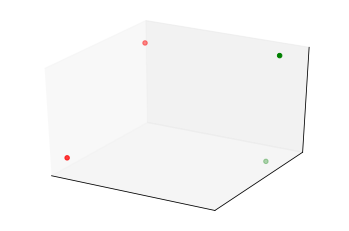

In [3]:
colors = ["red"] * n_perClass + ["green"] * n_perClass
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d', xticks=[], yticks=[], zticks=[])
ax.scatter(data[:, 0], data[:, 1], data[:, 2], c=colors)

The high-dimensional space is endowed with some measure of distance, the Euclidean distance being the simplest case. We can calculate all pairwise distances between the data points:

In [4]:
w = pairwise_distances(data)
w

array([[0.        , 0.41555907, 0.88010178, 0.77280287],
       [0.41555907, 0.        , 0.98864754, 0.98646897],
       [0.88010178, 0.98864754, 0.        , 0.27716198],
       [0.77280287, 0.98646897, 0.27716198, 0.        ]])

This matrix is sometimes called the Gram matrix (sometimes also the kernel matrix). It can be thought of as the **weighted adjacency matrix of a graph**: nodes represent data instances and distances are encoded as a property of the edges that connect them. In general, this is a dense graph with many edges -- sparsity can be improved by a distance function that gets exponentially smaller.

- Some background about graphs...  *In the most common sense of the term, a graph is an ordered pair $G = (V, E)$ comprising a set $V$ of vertices (also called nodes or points) together with a set $E$ of edges (also called links or lines), which are 2-element subsets of $V$ (i.e. an edge is associated with two vertices and that association takes the form of the unordered pair comprising those two vertices).  A cut is a set of edges that separate the vertices $V$ into two disjoint subsets of vertices $V_1$ and $V_2$.*


**What can we do with this graph to find the clusters?** We could look for the **max-cut**, that is, the collection of edges that would split the graph in exactly two if removed, while maximizing the total weight of these edges [[1](#1)]. This is a well-known NP-hard problem, but it also **very naturally maps to an Ising model**.

Let us assume that we defined a cut splitting the graph into two subset of nodes $V_1$ and $V_2$.  The spin variables $\sigma_i \in \{-1, +1\}$ take on value $\sigma_i = +1$ if a data instance is in cluster 1 (nodes $V_1$ in the graph) and $\sigma_i = -1$ if the data instance is in cluster 2 (nodes $V_2$ in the graph). The cost of such a cut is therefore given as the sums of the weights **going accross the cut**. In clustering, the main assumption is that **distant points belong to different clusters; hence maximizing the overall sum of all weights (distances) between nodes with different labels represents a natural clustering algorithm**.   Denoting the cross-class edges $\delta$ as the intersection set of $V_1$ and $V_2$, the cost function is given by:

$$
\text{cut}(V_1, V_2) = \sum_{i\in V_1, j\in V_2} w_{ij} = \frac{1}{2}\sum_{(i, j) \in \delta } w_{ij}
$$

where we take advantage of the symmetry of the adjacency matrix.  Transforming the sum over the cut to a sum over all vertices in $V$, the cost function can be expressed as:

$$
\text{cut}(V_1, V_2) = \frac{1}{4} \sum_{i, j\in V} w_{ij} \big( 1- \sigma_i \sigma_j \big)
$$


By taking the negative of this, we can directly solve the problem by a quantum optimizer.

# Solving the max-cut problem by QAOA

Most quantum computing frameworks have convenience functions defined for common graph optimization algorithms, and max-cut is a staple. This reduces our task to importing the relevant functions:

In [6]:
from qiskit_aqua import get_aer_backend, QuantumInstance
from qiskit_aqua.algorithms import QAOA
from qiskit_aqua.components.optimizers import COBYLA
from qiskit_aqua.translators.ising import maxcut

Setting $p=1$ in the QAOA algorithm, we can initialize it with the max-cut problem.

In [7]:
qubit_operators, offset = maxcut.get_maxcut_qubitops(w)
qaoa = QAOA(qubit_operators, COBYLA(), p=1, operator_mode='matrix')

Here the choice of the classical optimizer `COBYLA` was arbitrary. Let us run this and analyze the solution. 

(Note that ``BasicAer`` is a remarkably inefficient simulator so this step can take very long.  This is why we consider only 4 data instances.)

In [8]:
quantum_instance = QuantumInstance(get_aer_backend('statevector_simulator'), shots=100)
result = qaoa.run(quantum_instance)

In [9]:
x = maxcut.sample_most_likely(result['eigvecs'][0])
graph_solution = maxcut.get_graph_solution(x)
print('solution:', maxcut.get_graph_solution(x))

solution: [0. 0. 1. 1.]


Looking at the solution, the cut matches the clustering structure.

# Solving the max-cut problem by annealing

Naturally, the same problem can be solved on an annealer. Our only task is to translate the couplings and the on-site fields to match the programming interface:

In [10]:
import dimod

num_reads = 10

h = {_: 0 for _ in range(n_instances)}
J = {(i, j): w[i, j] for i in range(n_instances) for j in range(i+1, n_instances)}

model = dimod.BinaryQuadraticModel(h, J, 0.0, dimod.SPIN)
sampler = dimod.SimulatedAnnealingSampler()
response = sampler.sample(model, num_reads = num_reads)

responseData = list(response.data())

print("Energy of samples:")
for solution in responseData:
    print("Energy:", solution.energy, "Sample:", solution.sample)

Energy of samples:
Energy: -2.935300099242103 Sample: {0: 1, 1: 1, 2: -1, 3: -1}
Energy: -2.935300099242103 Sample: {0: -1, 1: -1, 2: 1, 3: 1}
Energy: -2.935300099242103 Sample: {0: 1, 1: 1, 2: -1, 3: -1}
Energy: -2.935300099242103 Sample: {0: -1, 1: -1, 2: 1, 3: 1}
Energy: -2.935300099242103 Sample: {0: 1, 1: 1, 2: -1, 3: -1}
Energy: -2.935300099242103 Sample: {0: 1, 1: 1, 2: -1, 3: -1}
Energy: -2.935300099242103 Sample: {0: -1, 1: -1, 2: 1, 3: 1}
Energy: -2.935300099242103 Sample: {0: -1, 1: -1, 2: 1, 3: 1}
Energy: -2.935300099242103 Sample: {0: 1, 1: 1, 2: -1, 3: -1}
Energy: -2.935300099242103 Sample: {0: 1, 1: 1, 2: -1, 3: -1}


Once again, we can see that the ground state corresponds to the expected spin state.

In [11]:
def verifEnergy(responseData, responseID, couplingConstants):
    resSample, resEnergy = responseData[responseID].sample, responseData[responseID].energy
    myEnergy = sum([couplingConstants[i, j] * resSample[i] * resSample[j] for i, j in couplingConstants])
    print(myEnergy, resEnergy, myEnergy - resEnergy)
    
[verifEnergy(responseData, _, J) for _ in range(num_reads)]

-2.935300099242103 -2.935300099242103 0.0
-2.935300099242103 -2.935300099242103 0.0
-2.935300099242103 -2.935300099242103 0.0
-2.935300099242103 -2.935300099242103 0.0
-2.935300099242103 -2.935300099242103 0.0
-2.935300099242103 -2.935300099242103 0.0
-2.935300099242103 -2.935300099242103 0.0
-2.935300099242103 -2.935300099242103 0.0
-2.935300099242103 -2.935300099242103 0.0
-2.935300099242103 -2.935300099242103 0.0


[None, None, None, None, None, None, None, None, None, None]